---
title: "Model Selection and Hyperparameter Tuning using Optuna for Loan Charge-Off Prediction"
author: "Daniel Smith"
date: "2024-03-19"
categories: [Python, Pandas, Seaborn, TensorFlow, Optuna]
title-block-banner: false
jupyter: python3
image: 'preview.png'
draft: false
description:  "After cleaning and preprocessing a modified LendingClub dataset of loan applicants I implement an Optuna study for both model selection and hyperparameter tuning with cross-validation to choose a model to predict if an unseen applicant will repay their loan."
---

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import optuna

In [2]:
print("Python version:")
!python --version

Python version:
Python 3.11.4


In [3]:
print("Optuna version:")
print(optuna.__version__)

Optuna version:
3.5.0


In [4]:
print("TensorFlow version:")
print(tf.__version__)

TensorFlow version:
2.14.0


# Data Imports

----
-----
We use a modified LendingClub dataset from Kaggle, found in a [Udemy course by Jose Portilla](https://www.udemy.com/course/python-for-data-science-and-machine-learning-bootcamp/?couponCode=LETSLEARNNOWPP).

Before preprocessing, the dataset has the following features:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>LoanStatNew</th>
      <th>Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>loan_amnt</td>
      <td>The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.</td>
    </tr>
    <tr>
      <th>1</th>
      <td>term</td>
      <td>The number of payments on the loan. Values are in months and can be either 36 or 60.</td>
    </tr>
    <tr>
      <th>2</th>
      <td>int_rate</td>
      <td>Interest Rate on the loan</td>
    </tr>
    <tr>
      <th>3</th>
      <td>installment</td>
      <td>The monthly payment owed by the borrower if the loan originates.</td>
    </tr>
    <tr>
      <th>4</th>
      <td>grade</td>
      <td>LC assigned loan grade</td>
    </tr>
    <tr>
      <th>5</th>
      <td>sub_grade</td>
      <td>LC assigned loan subgrade</td>
    </tr>
    <tr>
      <th>6</th>
      <td>emp_title</td>
      <td>The job title supplied by the Borrower when applying for the loan.*</td>
    </tr>
    <tr>
      <th>7</th>
      <td>emp_length</td>
      <td>Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.</td>
    </tr>
    <tr>
      <th>8</th>
      <td>home_ownership</td>
      <td>The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER</td>
    </tr>
    <tr>
      <th>9</th>
      <td>annual_inc</td>
      <td>The self-reported annual income provided by the borrower during registration.</td>
    </tr>
    <tr>
      <th>10</th>
      <td>verification_status</td>
      <td>Indicates if income was verified by LC, not verified, or if the income source was verified</td>
    </tr>
    <tr>
      <th>11</th>
      <td>issue_d</td>
      <td>The month which the loan was funded</td>
    </tr>
    <tr>
      <th>12</th>
      <td>loan_status</td>
      <td>Current status of the loan</td>
    </tr>
    <tr>
      <th>13</th>
      <td>purpose</td>
      <td>A category provided by the borrower for the loan request.</td>
    </tr>
    <tr>
      <th>14</th>
      <td>title</td>
      <td>The loan title provided by the borrower</td>
    </tr>
    <tr>
      <th>15</th>
      <td>zip_code</td>
      <td>The first 3 numbers of the zip code provided by the borrower in the loan application.</td>
    </tr>
    <tr>
      <th>16</th>
      <td>addr_state</td>
      <td>The state provided by the borrower in the loan application</td>
    </tr>
    <tr>
      <th>17</th>
      <td>dti</td>
      <td>A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.</td>
    </tr>
    <tr>
      <th>18</th>
      <td>earliest_cr_line</td>
      <td>The month the borrower's earliest reported credit line was opened</td>
    </tr>
    <tr>
      <th>19</th>
      <td>open_acc</td>
      <td>The number of open credit lines in the borrower's credit file.</td>
    </tr>
    <tr>
      <th>20</th>
      <td>pub_rec</td>
      <td>Number of derogatory public records</td>
    </tr>
    <tr>
      <th>21</th>
      <td>revol_bal</td>
      <td>Total credit revolving balance</td>
    </tr>
    <tr>
      <th>22</th>
      <td>revol_util</td>
      <td>Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.</td>
    </tr>
    <tr>
      <th>23</th>
      <td>total_acc</td>
      <td>The total number of credit lines currently in the borrower's credit file</td>
    </tr>
    <tr>
      <th>24</th>
      <td>initial_list_status</td>
      <td>The initial listing status of the loan. Possible values are – W, F</td>
    </tr>
    <tr>
      <th>25</th>
      <td>application_type</td>
      <td>Indicates whether the loan is an individual application or a joint application with two co-borrowers</td>
    </tr>
    <tr>
      <th>26</th>
      <td>mort_acc</td>
      <td>Number of mortgage accounts.</td>
    </tr>
    <tr>
      <th>27</th>
      <td>pub_rec_bankruptcies</td>
      <td>Number of public record bankruptcies</td>
    </tr>
  </tbody>
</table>

---
----

In [5]:
df = pd.read_csv('lending_club_loan.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

In [7]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


# Exploratory Data Analysis

In this section I produce some figures while exploring the distribution of the dataset. 

The uninterested should feel free to skip forward a section

<Axes: xlabel='loan_status', ylabel='count'>

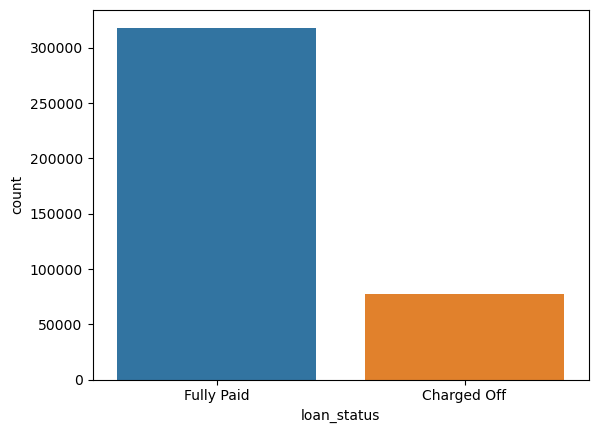

In [8]:
sns.countplot(x='loan_status',data=df)

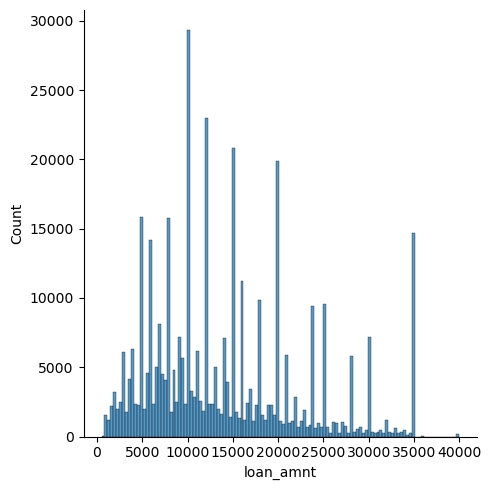

In [9]:
sns.displot(df['loan_amnt'],kde=False)

In [10]:
df.corr(numeric_only=True)

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
loan_amnt,1.000000,0.168921,0.953929,0.336887,0.016636,0.198556,-0.077779,0.328320,0.099911,0.223886,0.222315,-0.106539
int_rate,0.168921,1.000000,0.162758,-0.056771,0.079038,0.011649,0.060986,-0.011280,0.293659,-0.036404,-0.082583,0.057450
installment,0.953929,0.162758,1.000000,0.330381,0.015786,0.188973,-0.067892,0.316455,0.123915,0.202430,0.193694,-0.098628
annual_inc,0.336887,-0.056771,0.330381,1.000000,-0.081685,0.136150,-0.013720,0.299773,0.027871,0.193023,0.236320,-0.050162
dti,0.016636,0.079038,0.015786,-0.081685,1.000000,0.136181,-0.017639,0.063571,0.088375,0.102128,-0.025439,-0.014558
open_acc,0.198556,0.011649,0.188973,0.136150,0.136181,1.000000,-0.018392,0.221192,-0.131420,0.680728,0.109205,-0.027732
pub_rec,-0.077779,0.060986,-0.067892,-0.013720,-0.017639,-0.018392,1.000000,-0.101664,-0.075910,0.019723,0.011552,0.699408
revol_bal,0.328320,-0.011280,0.316455,0.299773,0.063571,0.221192,-0.101664,1.000000,0.226346,0.191616,0.194925,-0.124532
revol_util,0.099911,0.293659,0.123915,0.027871,0.088375,-0.131420,-0.075910,0.226346,1.000000,-0.104273,0.007514,-0.086751
total_acc,0.223886,-0.036404,0.202430,0.193023,0.102128,0.680728,0.019723,0.191616,-0.104273,1.000000,0.381072,0.042035


<Axes: >

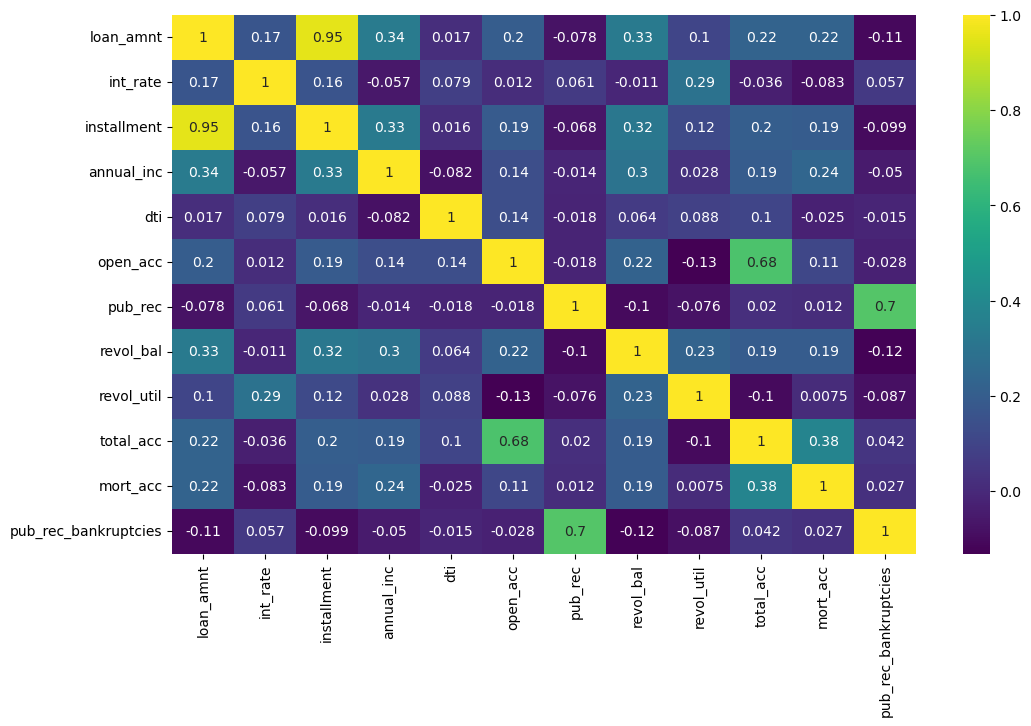

In [11]:
plt.figure(figsize=(12,7))
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap='viridis')

<Axes: xlabel='installment', ylabel='loan_amnt'>

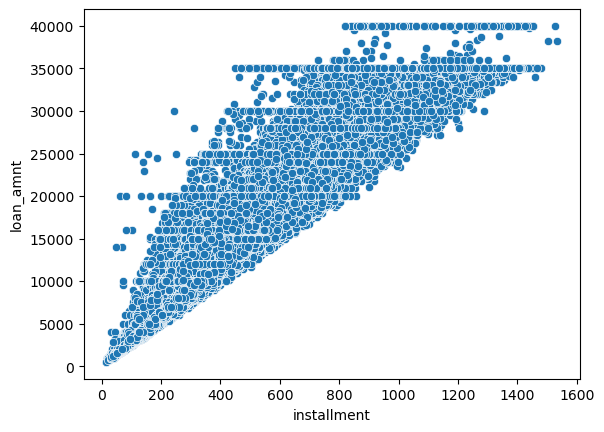

In [12]:
sns.scatterplot(data=df,x='installment',y='loan_amnt')

<Axes: xlabel='loan_status', ylabel='loan_amnt'>

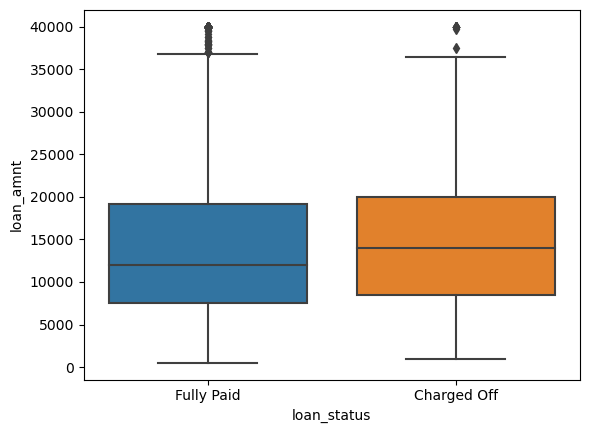

In [13]:
sns.boxplot(data=df,x='loan_status',y='loan_amnt')

In [14]:
df.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,15126.300967,8505.090557,1000.0,8525.0,14000.0,20000.0,40000.0
Fully Paid,318357.0,13866.878771,8302.319699,500.0,7500.0,12000.0,19225.0,40000.0


In [15]:
df['grade'].unique()

array(['B', 'A', 'C', 'E', 'D', 'F', 'G'], dtype=object)

In [16]:
df['sub_grade'].unique()

array(['B4', 'B5', 'B3', 'A2', 'C5', 'C3', 'A1', 'B2', 'C1', 'A5', 'E4',
       'A4', 'A3', 'D1', 'C2', 'B1', 'D3', 'D5', 'D2', 'E1', 'E2', 'E5',
       'F4', 'E3', 'D4', 'G1', 'F5', 'G2', 'C4', 'F1', 'F3', 'G5', 'G4',
       'F2', 'G3'], dtype=object)

<Axes: xlabel='grade', ylabel='count'>

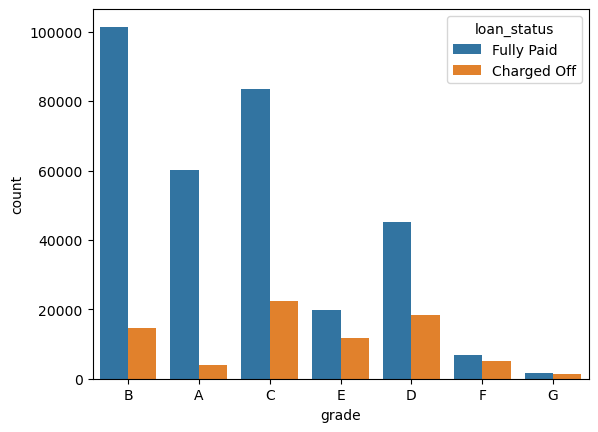

In [17]:
sns.countplot(data=df,x='grade',hue='loan_status')

<Axes: xlabel='sub_grade', ylabel='count'>

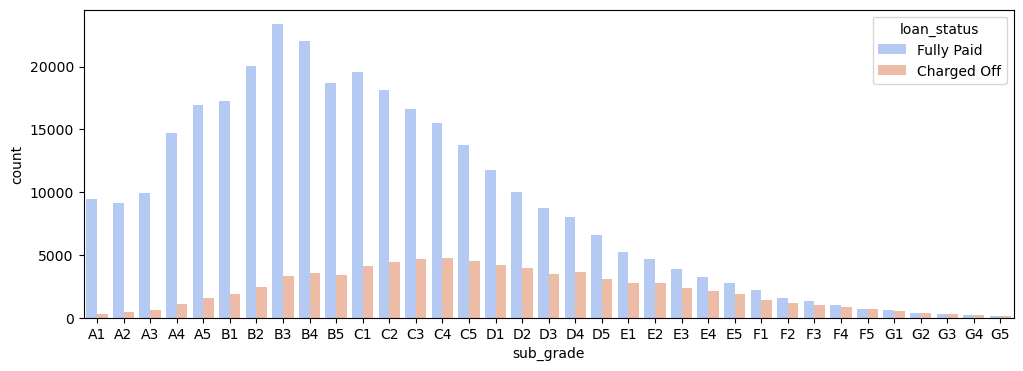

In [18]:
subgrade_order = sorted(df['sub_grade'].unique())

plt.figure(figsize=(12,4))
sns.countplot(data=df,
              x='sub_grade',
              order=subgrade_order,
              palette='coolwarm',
              hue='loan_status')

<Axes: xlabel='sub_grade', ylabel='count'>

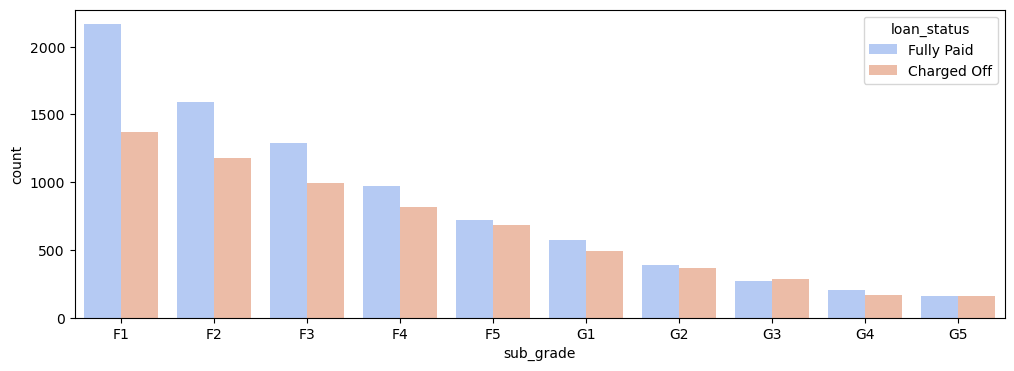

In [19]:
f_g = df[(df['grade'] == 'G') | (df['grade'] == 'F')]

subgrade_order = sorted(f_g['sub_grade'].unique())

plt.figure(figsize=(12,4))
sns.countplot(data=f_g,
              x='sub_grade',
              order=subgrade_order,
              palette='coolwarm',
              hue='loan_status')

# Missing Values and Feature Engineering

Some of the columns in the dataframe have missing values which we need to fill before we can hope to train any machine learning models.

In this section we also conduct "feature engineering", creating new columns from the existing columns in order to try and enhance the expressibility of the data.

The categorical features also need to be encoded. The machine learning algorithms I want to search over cannot all handle textual data such as 'False', so we need to conduct [One Hot Encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) to ensure the dataframe only consists of numeric columns.

In [20]:
df['loan_repaid'] = (df['loan_status'] == 'Fully Paid').astype(int)
df[['loan_repaid','loan_status']]

,loan_repaid,loan_status
0,1,Fully Paid
1,1,Fully Paid
2,1,Fully Paid
3,1,Fully Paid
4,0,Charged Off
...,...,...
396025,1,Fully Paid
396026,1,Fully Paid
396027,1,Fully Paid
396028,1,Fully Paid


<Axes: >

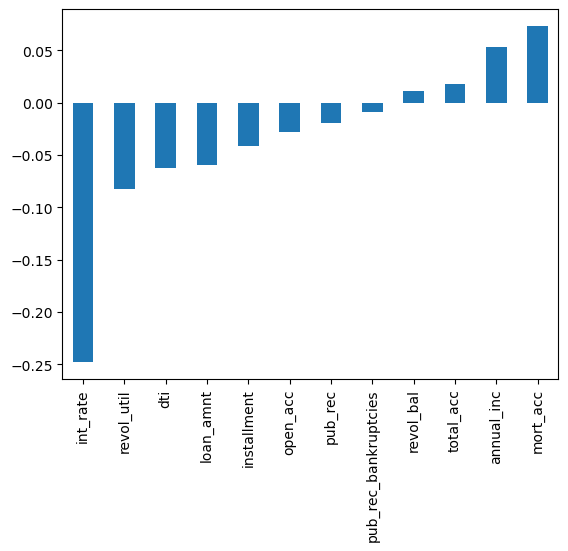

In [21]:
df.corr(numeric_only=True)['loan_repaid'].sort_values().drop('loan_repaid').plot(kind='bar')

Looking at how many missing values are present in each column of the dataframe:

In [22]:
df.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1756
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
loan_repaid                 0
dtype: int64

Defining a function to print what percentages of columns these missing values correspond too.

In [23]:
def percentage_null(df):
    percentage_missing = (df.isnull().sum()/len(df))*100
    print('\nPercentages of values missing:\n')
    print(percentage_missing.round(2))

In [24]:
percentage_null(df)


Percentages of values missing:

loan_amnt               0.00
term                    0.00
int_rate                0.00
installment             0.00
grade                   0.00
sub_grade               0.00
emp_title               5.79
emp_length              4.62
home_ownership          0.00
annual_inc              0.00
verification_status     0.00
issue_d                 0.00
loan_status             0.00
purpose                 0.00
title                   0.44
dti                     0.00
earliest_cr_line        0.00
open_acc                0.00
pub_rec                 0.00
revol_bal               0.00
revol_util              0.07
total_acc               0.00
initial_list_status     0.00
application_type        0.00
mort_acc                9.54
pub_rec_bankruptcies    0.14
address                 0.00
loan_repaid             0.00
dtype: float64


In [25]:
df['title']

0                        Vacation
1              Debt consolidation
2         Credit card refinancing
3         Credit card refinancing
4           Credit Card Refinance
                   ...           
396025         Debt consolidation
396026         Debt consolidation
396027       pay off credit cards
396028              Loanforpayoff
396029          Toxic Debt Payoff
Name: title, Length: 396030, dtype: object

In [26]:
df['purpose']

0                   vacation
1         debt_consolidation
2                credit_card
3                credit_card
4                credit_card
                 ...        
396025    debt_consolidation
396026    debt_consolidation
396027    debt_consolidation
396028    debt_consolidation
396029    debt_consolidation
Name: purpose, Length: 396030, dtype: object

The columns `title` and `purpose` are duplicates, so we can drop one without losing any information.

In [27]:
df = df.drop('title',axis=1)

## `emp_title` and `emp_length`

In [28]:
df['emp_title']

0                        Marketing
1                  Credit analyst 
2                     Statistician
3                  Client Advocate
4          Destiny Management Inc.
                    ...           
396025            licensed bankere
396026                       Agent
396027                City Carrier
396028        Gracon Services, Inc
396029    Internal Revenue Service
Name: emp_title, Length: 396030, dtype: object

In [29]:
df['emp_title'].nunique()

173105

`emp_title` has too many unique values to encode

In [30]:
df = df.drop('emp_title', axis=1)

In [31]:
df['emp_length']

0         10+ years
1           4 years
2          < 1 year
3           6 years
4           9 years
            ...    
396025      2 years
396026      5 years
396027    10+ years
396028    10+ years
396029    10+ years
Name: emp_length, Length: 396030, dtype: object

In [32]:
sorted(df['emp_length'].dropna().unique())

['1 year',
 '10+ years',
 '2 years',
 '3 years',
 '4 years',
 '5 years',
 '6 years',
 '7 years',
 '8 years',
 '9 years',
 '< 1 year']

In [33]:
ordered_emp_lengths = ['< 1 year',
 '1 year',
 '2 years',
 '3 years',
 '4 years',
 '5 years',
 '6 years',
 '7 years',
 '8 years',
 '9 years',
 '10+ years']

<Axes: xlabel='emp_length', ylabel='count'>

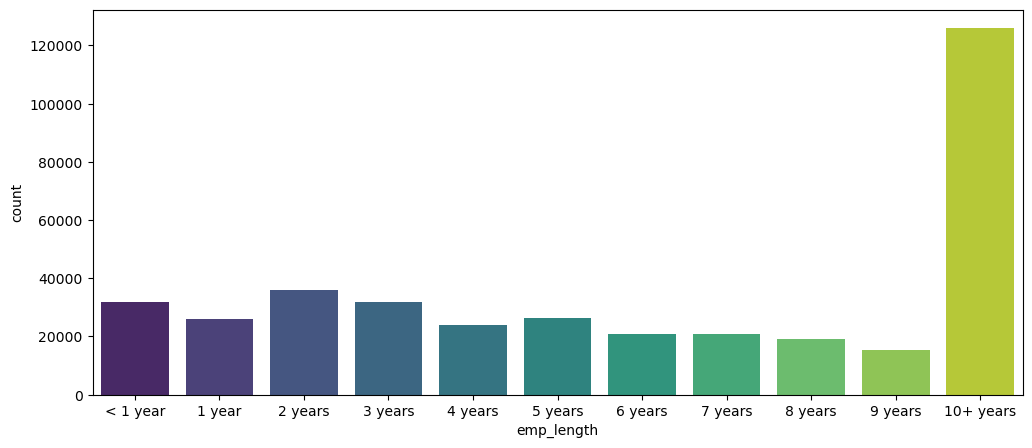

In [34]:
plt.figure(figsize=(12,5))
sns.countplot(data=df,
              x='emp_length',
              order=ordered_emp_lengths,
              palette='viridis')

<Axes: xlabel='emp_length', ylabel='count'>

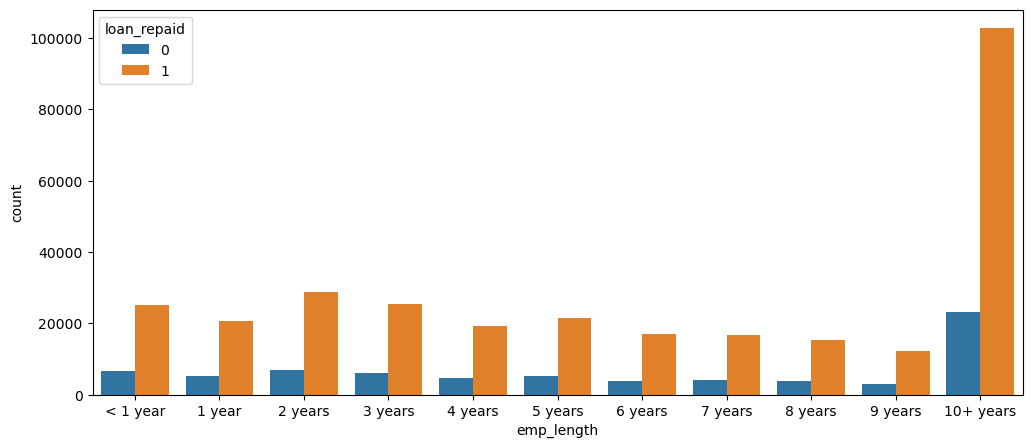

In [35]:
plt.figure(figsize=(12,5))
sns.countplot(data=df,
              x='emp_length',
              order=ordered_emp_lengths,
              hue='loan_repaid')

<Axes: xlabel='emp_length'>

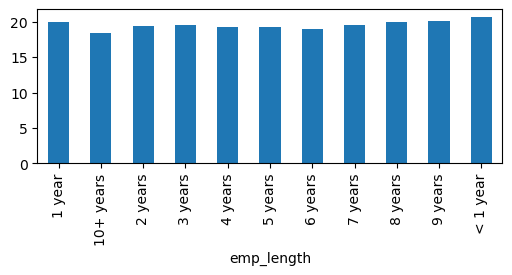

In [36]:
emp_co = df[df['loan_repaid'] == 0].groupby('emp_length').count()['loan_repaid']
emp_fp = df[df['loan_repaid'] == 1].groupby('emp_length').count()['loan_repaid']

plt.figure(figsize=(6,2))
((emp_co/(emp_fp+emp_co))*100).plot(kind='bar')

`emp_length` doesn't look to tell us anything about `loan_repaid`. Very similar fractions of all employment lengths did not manage to repay their loans, so we drop this column too.

In [37]:
df = df.drop('emp_length',axis=1)

## Filling `mort_acc` using `total_acc`

In [38]:
percentage_null(df)


Percentages of values missing:

loan_amnt               0.00
term                    0.00
int_rate                0.00
installment             0.00
grade                   0.00
sub_grade               0.00
home_ownership          0.00
annual_inc              0.00
verification_status     0.00
issue_d                 0.00
loan_status             0.00
purpose                 0.00
dti                     0.00
earliest_cr_line        0.00
open_acc                0.00
pub_rec                 0.00
revol_bal               0.00
revol_util              0.07
total_acc               0.00
initial_list_status     0.00
application_type        0.00
mort_acc                9.54
pub_rec_bankruptcies    0.14
address                 0.00
loan_repaid             0.00
dtype: float64


In [39]:
df['mort_acc'].value_counts()

mort_acc
0.0     139777
1.0      60416
2.0      49948
3.0      38049
4.0      27887
5.0      18194
6.0      11069
7.0       6052
8.0       3121
9.0       1656
10.0       865
11.0       479
12.0       264
13.0       146
14.0       107
15.0        61
16.0        37
17.0        22
18.0        18
19.0        15
20.0        13
24.0        10
22.0         7
21.0         4
25.0         4
27.0         3
32.0         2
31.0         2
23.0         2
26.0         2
28.0         1
30.0         1
34.0         1
Name: count, dtype: int64

In [40]:
df.corr(numeric_only=True)['mort_acc'].sort_values()

int_rate               -0.082583
dti                    -0.025439
revol_util              0.007514
pub_rec                 0.011552
pub_rec_bankruptcies    0.027239
loan_repaid             0.073111
open_acc                0.109205
installment             0.193694
revol_bal               0.194925
loan_amnt               0.222315
annual_inc              0.236320
total_acc               0.381072
mort_acc                1.000000
Name: mort_acc, dtype: float64

`mort_acc` correlates most strongly with `total_acc`, so we can leverage the fact that `total_acc` has no missing values to fill the missing values in `mort_acc` 

In [41]:
total_acc_avgs = df.groupby('total_acc').mean(numeric_only=True)['mort_acc']

In [42]:
def fill_mort_acc(total_acc,mort_acc):
    
    if np.isnan(mort_acc):
        return total_acc_avgs[total_acc]
    else:
        return mort_acc

In [43]:
df['mort_acc'] = df.apply(lambda x: fill_mort_acc(x['total_acc'],x['mort_acc']),axis=1)

In [44]:
df.isnull().sum()

loan_amnt                 0
term                      0
int_rate                  0
installment               0
grade                     0
sub_grade                 0
home_ownership            0
annual_inc                0
verification_status       0
issue_d                   0
loan_status               0
purpose                   0
dti                       0
earliest_cr_line          0
open_acc                  0
pub_rec                   0
revol_bal                 0
revol_util              276
total_acc                 0
initial_list_status       0
application_type          0
mort_acc                  0
pub_rec_bankruptcies    535
address                   0
loan_repaid               0
dtype: int64

In [45]:
percentage_null(df)


Percentages of values missing:

loan_amnt               0.00
term                    0.00
int_rate                0.00
installment             0.00
grade                   0.00
sub_grade               0.00
home_ownership          0.00
annual_inc              0.00
verification_status     0.00
issue_d                 0.00
loan_status             0.00
purpose                 0.00
dti                     0.00
earliest_cr_line        0.00
open_acc                0.00
pub_rec                 0.00
revol_bal               0.00
revol_util              0.07
total_acc               0.00
initial_list_status     0.00
application_type        0.00
mort_acc                0.00
pub_rec_bankruptcies    0.14
address                 0.00
loan_repaid             0.00
dtype: float64


Only a neglible amount of rows still have missing data points, so we now feel comfortable dropping these rows

In [46]:
df = df.dropna()

In [47]:
percentage_null(df)


Percentages of values missing:

loan_amnt               0.0
term                    0.0
int_rate                0.0
installment             0.0
grade                   0.0
sub_grade               0.0
home_ownership          0.0
annual_inc              0.0
verification_status     0.0
issue_d                 0.0
loan_status             0.0
purpose                 0.0
dti                     0.0
earliest_cr_line        0.0
open_acc                0.0
pub_rec                 0.0
revol_bal               0.0
revol_util              0.0
total_acc               0.0
initial_list_status     0.0
application_type        0.0
mort_acc                0.0
pub_rec_bankruptcies    0.0
address                 0.0
loan_repaid             0.0
dtype: float64


## Categorical Features

Here we treat the categorical features such as `home_ownership` and `purpose` by either dropping them or one-hot encoding them as to end with a dataframe consisting only of numeric features.

In [48]:
df.select_dtypes(['object']).columns

Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'earliest_cr_line',
       'initial_list_status', 'application_type', 'address'],
      dtype='object')

In [49]:
df['term'].value_counts()

term
 36 months    301247
 60 months     93972
Name: count, dtype: int64

In [50]:
df['term'] = df['term'].apply(lambda x: int(x.split()[0]))

In [51]:
df['term']

0         36
1         36
2         36
3         36
4         60
          ..
396025    60
396026    36
396027    36
396028    60
396029    36
Name: term, Length: 395219, dtype: int64

In [52]:
df['zip_code'] = df['address'].apply(lambda address: address[-5:])

In [53]:
df['zip_code'].value_counts()

zip_code
70466    56880
22690    56413
30723    56402
48052    55811
00813    45725
29597    45393
05113    45300
11650    11210
93700    11126
86630    10959
Name: count, dtype: int64

In [54]:
df['home_ownership'].value_counts()

home_ownership
MORTGAGE    198022
RENT        159395
OWN          37660
OTHER          110
NONE            29
ANY              3
Name: count, dtype: int64

In [55]:
df['home_ownership'] = df['home_ownership'].replace(['NONE','ANY'],'OTHER')

In [56]:
df['home_ownership'].value_counts()

home_ownership
MORTGAGE    198022
RENT        159395
OWN          37660
OTHER          142
Name: count, dtype: int64

one-hot encoding with `pandas.get_dummies`:

In [57]:
columns_to_1hot = ['home_ownership',
                   'verification_status',
                   'application_type',
                   'initial_list_status',
                   'purpose',
                   'zip_code',
                   'sub_grade']

In [58]:
df = pd.get_dummies(data=df,
                    columns=columns_to_1hot,
                    drop_first=True,
                    dtype=int)

In [59]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'annual_inc',
       'issue_d', 'loan_status', 'dti', 'earliest_cr_line', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc',
       'pub_rec_bankruptcies', 'address', 'loan_repaid',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Source Verified', 'verification_status_Verified',
       'application_type_INDIVIDUAL', 'application_type_JOINT',
       'initial_list_status_w', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'zip_code_05113',
       'zip_code_11650', 'zip_code_22690', 'zip_code_29597', 'zip_code_30723',
       'zip_code_48052', 'zip_code_70466', 'zip

In [60]:
df['earliest_cr_line']

0         Jun-1990
1         Jul-2004
2         Aug-2007
3         Sep-2006
4         Mar-1999
            ...   
396025    Nov-2004
396026    Feb-2006
396027    Mar-1997
396028    Nov-1990
396029    Sep-1998
Name: earliest_cr_line, Length: 395219, dtype: object

In [61]:
df['earliest_cr_year'] = df['earliest_cr_line'].apply(lambda x: int(x.split('-')[-1]))

In [62]:
df['earliest_cr_year']

0         1990
1         2004
2         2007
3         2006
4         1999
          ... 
396025    2004
396026    2006
396027    1997
396028    1990
396029    1998
Name: earliest_cr_year, Length: 395219, dtype: int64

Dropping categorical features not worth encoding:

In [63]:
columns_to_drop = ['earliest_cr_line',
                   'grade',
                   'issue_d',
                   'loan_status',
                   'address']

In [64]:
df = df.drop(columns_to_drop,axis=1)

# Preprocessing

After our feature engineering we have the following dataset:

In [65]:
df

,loan_amnt,term,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,...,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,earliest_cr_year
0,10000.0,36,11.44,329.48,117000.0,26.24,16.0,0.0,36369.0,41.8,...,0,0,0,0,0,0,0,0,0,1990
1,8000.0,36,11.99,265.68,65000.0,22.05,17.0,0.0,20131.0,53.3,...,0,0,0,0,0,0,0,0,0,2004
2,15600.0,36,10.49,506.97,43057.0,12.79,13.0,0.0,11987.0,92.2,...,0,0,0,0,0,0,0,0,0,2007
3,7200.0,36,6.49,220.65,54000.0,2.60,6.0,0.0,5472.0,21.5,...,0,0,0,0,0,0,0,0,0,2006
4,24375.0,60,17.27,609.33,55000.0,33.95,13.0,0.0,24584.0,69.8,...,0,0,0,0,0,0,0,0,0,1999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396025,10000.0,60,10.99,217.38,40000.0,15.63,6.0,0.0,1990.0,34.3,...,0,0,0,0,0,0,0,0,0,2004
396026,21000.0,36,12.29,700.42,110000.0,21.45,6.0,0.0,43263.0,95.7,...,0,0,0,0,0,0,0,0,0,2006
396027,5000.0,36,9.99,161.32,56500.0,17.56,15.0,0.0,32704.0,66.9,...,0,0,0,0,0,0,0,0,0,1997
396028,21000.0,60,15.31,503.02,64000.0,15.88,9.0,0.0,15704.0,53.8,...,0,0,0,0,0,0,0,0,0,1990


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 395219 entries, 0 to 396029
Data columns (total 79 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            395219 non-null  float64
 1   term                                 395219 non-null  int64  
 2   int_rate                             395219 non-null  float64
 3   installment                          395219 non-null  float64
 4   annual_inc                           395219 non-null  float64
 5   dti                                  395219 non-null  float64
 6   open_acc                             395219 non-null  float64
 7   pub_rec                              395219 non-null  float64
 8   revol_bal                            395219 non-null  float64
 9   revol_util                           395219 non-null  float64
 10  total_acc                            395219 non-null  float64
 11  mort_acc          

In [67]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc', 'dti',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'mort_acc', 'pub_rec_bankruptcies', 'loan_repaid',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Source Verified', 'verification_status_Verified',
       'application_type_INDIVIDUAL', 'application_type_JOINT',
       'initial_list_status_w', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'zip_code_05113',
       'zip_code_11650', 'zip_code_22690', 'zip_code_29597', 'zip_code_30723',
       'zip_code_48052', 'zip_code_70466', 'zip_code_86630', 'zip_code_93700',
       'sub_grade_A2', 'sub_grade_A3', 's

## TRAIN/TEST SPLIT

Splitting the dataset into a training set and a test set:

(Note that cross-validation is performed inside the Optuna study, so we don't need to separate out a validation set here)

In [97]:
X = df.drop('loan_repaid', axis=1).values
y = df['loan_repaid'].values

features = df.columns.drop('loan_repaid')
target = 'loan_repaid'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=594)

# Convert to DataFrame and add column names
X_test_df = pd.DataFrame(X_test, columns=features)
y_test_df = pd.DataFrame(y_test, columns=[target])

df_test = pd.concat([X_test_df, y_test_df], axis=1)


In [98]:
print("Training set shape: ", X_train.shape, y_train.shape)
print("Test set shape: ", X_test.shape, y_test.shape)

Training set shape:  (375458, 78) (375458,)
Test set shape:  (19761, 78) (19761,)


## Normalising the Data

Some machine learning algorithms require all columns of the dataframe to consist of data on comparable scales. We use `StandardScalar` from scikit-learn to force this to be true.

There is rarely a drawback to normalising data like this. If in doubt, normalise.

In [73]:
scaler = StandardScaler()

In [74]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [75]:
X_train

array([[ 0.82301704, -0.55823002, -1.28362299, ..., -0.03076372,
        -0.02818382, -2.75955691],
       [-1.45078579, -0.55823002, -0.46740923, ..., -0.03076372,
        -0.02818382,  0.01934793],
       [-1.25930765, -0.55823002,  1.14265627, ..., -0.03076372,
        -0.02818382,  0.5751289 ],
       ...,
       [ 0.70334321, -0.55823002, -0.36901634, ..., -0.03076372,
        -0.02818382,  0.29723841],
       [ 1.90008154, -0.55823002, -0.33994571, ..., -0.03076372,
        -0.02818382, -1.78694022],
       [-0.52929727, -0.55823002, -1.17404909, ..., -0.03076372,
        -0.02818382, -0.25854255]])

# Model Selection and Hyperparameter Tuning with Optuna

The following two code cells implement an Optuna study to select a model with tuned hyperparameters to maximize the F1 score using cross-validation.

* We tune to maximize the F1 score of the classifiers rather than other metrics (such as classification accuracy) because the target `loan_repaid` is imbalanced.

* The model choices searched over are `DecisionTreeClassifier`, `RandomForestClassifier` and `LogisticRegression` from sklearn, `XGBClassifier` from XGBoost and artificial neural networks (of varying architecture) implemented in TensorFlow.

* The architecture of the neural networks is also tuned. The number of hidden layers is allowed to range from 1 to 6 (inclusive) and the number of units per hidden layer ranges from 32 to 512. The only activation function considered for the hidden layers is ReLU.

* I initially attempted to seperate the model selection and hyperparameter tuning by implementing a seperate Optuna study for each choice of model. Due to the size of the dataset this proved to be impractical. 

* Combining the model selection and hyperparameter tuning into a single Optuna study is elegant and allows for a more automated tuning process. It also allows for computational gains due to the shared hyperparameters between the tree-based models `DecisionTreeClasifier`, `RandomForestClassifier` and `XGBClassifier`. In expense for the higher degree of automation the user gains less insight into the reasons behind the model selection than they would if the model was selected manually.

* Attempts to incorporate a support vector machine (`SVC` from sklearn) into the study failed due to the training time required.


In [72]:
def objective(trial):
    model_type = trial.suggest_categorical('model_type', ['random_forest', 'decision_tree', 'xgboost', 'neural_network', 'logistic_regression'])
    
    # Initializing hyperparameters and model for each possible choice of model:
    
    if model_type in ['random_forest', 'decision_tree', 'xgboost']:
        # Shared hyperparameters for RandomForest, DecisionTree, and XGBoost:
        max_depth = trial.suggest_int('max_depth', 2, 32)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
        
        
        if model_type == 'decision_tree':
            
            model = DecisionTreeClassifier(
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                )
            
        elif model_type in  ['random_forest','xgboost']:
            # Shared hyperparameters for RandomForest and XGBoost but not DecisionTree:
            n_estimators = trial.suggest_int('n_estimators', 10, 300)
            
            if model_type == 'random_forest':
                
                model = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf,
                )
                       
            elif model_type == 'xgboost':
            
                learning_rate_xgb = trial.suggest_float('learning_rate_xgb', 0.01, 0.2)
                min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
                subsample = trial.suggest_float('subsample', 0.8, 1.0)
                reg_alpha = trial.suggest_float('reg_alpha', 0, 1.0)
                reg_lambda = trial.suggest_float('reg_lambda', 0, 1.0)
                colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
                gamma = trial.suggest_float('gamma', 0, 0.3)


                model = xgb.XGBClassifier(
                    learning_rate=learning_rate_xgb,
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_child_weight=min_child_weight,
                    subsample=subsample,
                    colsample_bytree=colsample_bytree,
                    gamma=gamma,
                    reg_alpha=reg_alpha,
                    reg_lambda=reg_lambda
                )
        
    
    elif model_type == 'logistic_regression':
        
        C = trial.suggest_float('C', 1e-5, 1e5, log=True)
        
        model = LogisticRegression(C=C, penalty='l2', max_iter=1000)
    
    
    elif model_type == 'neural_network':
        # NeuralNetwork-specific hyperparameters
        n_hidden_layers = trial.suggest_int('n_hidden_layers', 1, 6)
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
        batch_size = trial.suggest_categorical('batch_size',[64, 128, 256, 512])

        # Create the model
        model = Sequential()

        model.add(Dense(78, input_dim=78, activation='relu'))

        for i in range(n_hidden_layers):
            model.add(Dense(trial.suggest_categorical(f'n_units_{i+1}', [32, 64, 128, 256]), activation='relu'))
            model.add(Dropout(0.7))

        model.add(Dense(1, activation='sigmoid'))

        model.compile(
            loss=tf.keras.losses.BinaryCrossentropy(),
            optimizer=tf.keras.optimizers.Adam(learning_rate),
        )
        
    # Training with Cross-Validation

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=594)

    f1_scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_cv_train, X_cv_val = X_train[train_idx], X_train[val_idx]
        y_cv_train, y_cv_val = y_train[train_idx], y_train[val_idx]
        
        if model_type == 'neural_network':  # Neural Networks have a different syntax for model.fit
            model.fit(X_cv_train,
                      y_cv_train,
                      epochs=25,
                      batch_size=batch_size,
                      verbose=0)
        else:   
            model.fit(X_cv_train, y_cv_train)
        
        
        y_pred = np.round(model.predict(X_cv_val))
        f1_scores.append(f1_score(y_cv_val, y_pred))
    
    # Defining the score as the mean of the f1 scores for each fold
    
    score = np.mean(f1_scores)

    return score

In [79]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2024-03-18 22:06:40,744] A new study created in memory with name: no-name-57f734b0-8962-432d-bfb6-59471441a5f4
[I 2024-03-18 22:06:48,434] Trial 0 finished with value: 0.9348813881269542 and parameters: {'model_type': 'decision_tree', 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9348813881269542.
[I 2024-03-18 22:07:02,292] Trial 1 finished with value: 0.9351173423793565 and parameters: {'model_type': 'logistic_regression', 'C': 0.003376487874914207}. Best is trial 1 with value: 0.9351173423793565.
[I 2024-03-18 22:07:27,675] Trial 2 finished with value: 0.9308350280356752 and parameters: {'model_type': 'decision_tree', 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9351173423793565.
[I 2024-03-18 22:15:32,269] Trial 3 finished with value: 0.9350101137588679 and parameters: {'model_type': 'xgboost', 'max_depth': 28, 'min_samples_split': 5, 'min_samples_leaf': 1, 'n_estimators': 184, 'lea

2347/2347 [==============================] - 2s 779us/step


[I 2024-03-18 22:33:49,108] Trial 9 finished with value: 0.7142288590214265 and parameters: {'model_type': 'neural_network', 'n_hidden_layers': 5, 'learning_rate': 0.0007589397505339159, 'batch_size': 256, 'n_units_1': 32, 'n_units_2': 256, 'n_units_3': 128, 'n_units_4': 32, 'n_units_5': 32}. Best is trial 1 with value: 0.9351173423793565.
[I 2024-03-18 22:34:00,258] Trial 10 finished with value: 0.9351463663145185 and parameters: {'model_type': 'logistic_regression', 'C': 0.0016662846208744218}. Best is trial 10 with value: 0.9351463663145185.
[I 2024-03-18 22:34:09,393] Trial 11 finished with value: 0.9351004010191634 and parameters: {'model_type': 'logistic_regression', 'C': 0.0010317129078925686}. Best is trial 10 with value: 0.9351463663145185.
[I 2024-03-18 22:34:22,985] Trial 12 finished with value: 0.9351229667198243 and parameters: {'model_type': 'logistic_regression', 'C': 0.0034007756162559443}. Best is trial 10 with value: 0.9351463663145185.
[I 2024-03-18 22:35:58,457] Tri

In [85]:
params = study.best_params
print('Best parameters found by the study:\n', params)

Best parameters found by the study:
 {'model_type': 'random_forest', 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 297}


# Fitting the Best Model and Predicting on Test Set

The Optuna study tried all of the allowed models at least once, and settled on a `RandomForestClassifier` being the one that maxmised the mean of the F1 scores across each fold of the cross-validation.

Initialising and fitting this model to the train set:

In [77]:
params = {'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 297}

In [78]:
model = RandomForestClassifier(**params)

In [79]:
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=31, n_estimators=297)

In [80]:
y_pred = model.predict(X_test)

In [81]:
print('F1 Score of best model on test set:  ', f1_score(y_test, y_pred))

F1 Score of best model on test set:   0.9361802943702432


The true F1 score on the test set turned out to be even higher than the cross-val score of 0.935266998582307 found during the study.

In [82]:
print(confusion_matrix(y_test, y_pred))

[[ 1800  2112]
 [   43 15806]]


In [83]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.46      0.63      3912
           1       0.88      1.00      0.94     15849

    accuracy                           0.89     19761
   macro avg       0.93      0.73      0.78     19761
weighted avg       0.90      0.89      0.87     19761



# Examining Misclassified Points

Printing the features of a random false positive and a random false negative:

In [95]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [99]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

fp_indices = np.where((y_test == 0) & (y_pred == 1))
fn_indices = np.where((y_test == 1) & (y_pred == 0))

random_fp = np.random.choice(fp_indices[0])
random_fn = np.random.choice(fn_indices[0])

fp_row = df_test.iloc[random_fp].round(2)
fn_row = df_test.iloc[random_fn].round(2)

print("Random False Positive:\n")
print(f"Index={random_fp}")
print(f"y_pred={y_pred[random_fp]}, y_true={y_test[random_fp]}\n")
print(fp_row)
print("-----------------------------------------------------")

print("Random False Negative:\n")
print(f"Index={random_fn}")
print(f"y_pred={y_pred[random_fn]}, y_true={y_test[random_fn]}\n")
print(fn_row)

Random False Positive:

Index=2906
y_pred=1, y_true=0

loan_amnt                              22000.00
term                                      60.00
int_rate                                  22.15
installment                              609.50
annual_inc                             65000.00
dti                                       25.48
open_acc                                  13.00
pub_rec                                    1.00
revol_bal                               4418.00
revol_util                                38.00
total_acc                                 28.00
mort_acc                                   3.00
pub_rec_bankruptcies                       1.00
home_ownership_OTHER                       0.00
home_ownership_OWN                         0.00
home_ownership_RENT                        0.00
verification_status_Source Verified        1.00
verification_status_Verified               0.00
application_type_INDIVIDUAL                1.00
application_type_JOINT           

## Producing some visualisations investigating the distribution of misclassified points

In [86]:
misclassified = df.iloc[np.concatenate((fp_indices[0], fn_indices[0]))].copy()
misclassified.loc[:, 'type'] = ['FP' if i in fp_indices[0] else 'FN' for i in misclassified.index]

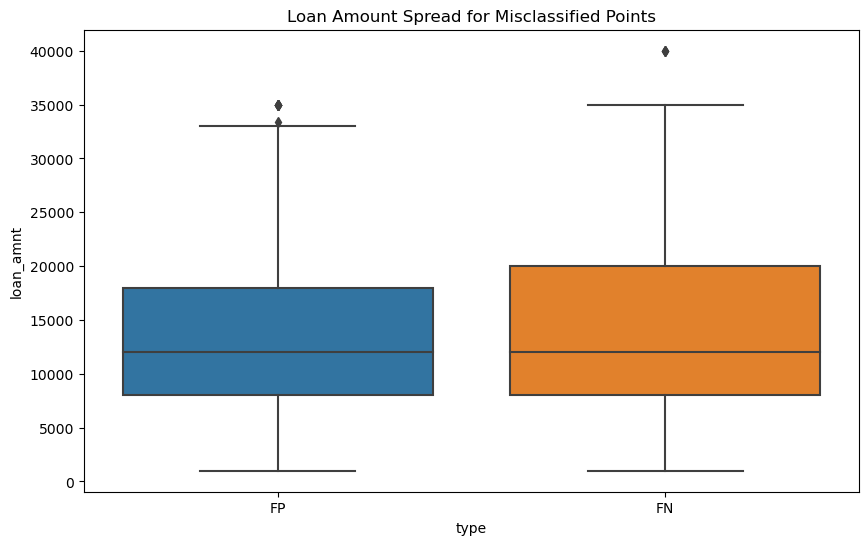

In [87]:
# Boxplot of loan_amnt
plt.figure(figsize=(10,6))
sns.boxplot(x='type', y='loan_amnt', data=misclassified)
plt.title('Loan Amount Spread for Misclassified Points')
plt.show()

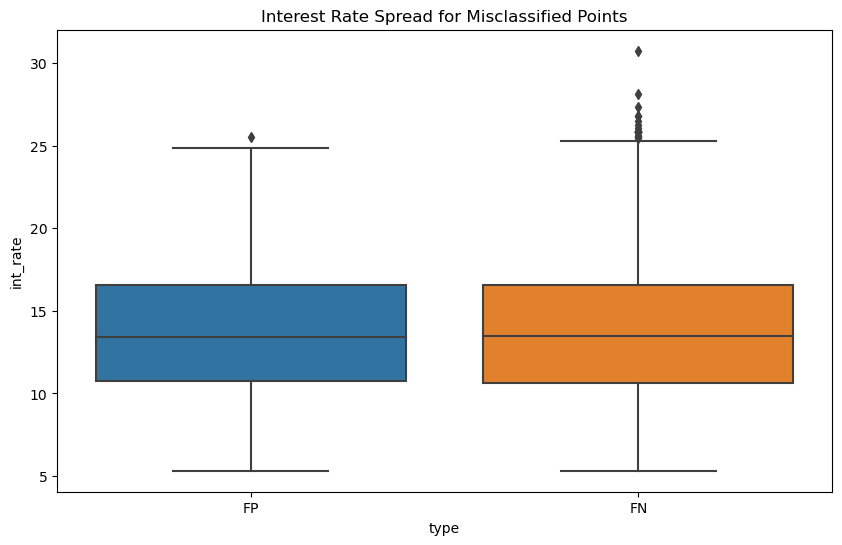

In [88]:
# Boxplot of int_rate
plt.figure(figsize=(10,6))
sns.boxplot(x='type', y='int_rate', data=misclassified)
plt.title('Interest Rate Spread for Misclassified Points')
plt.show()

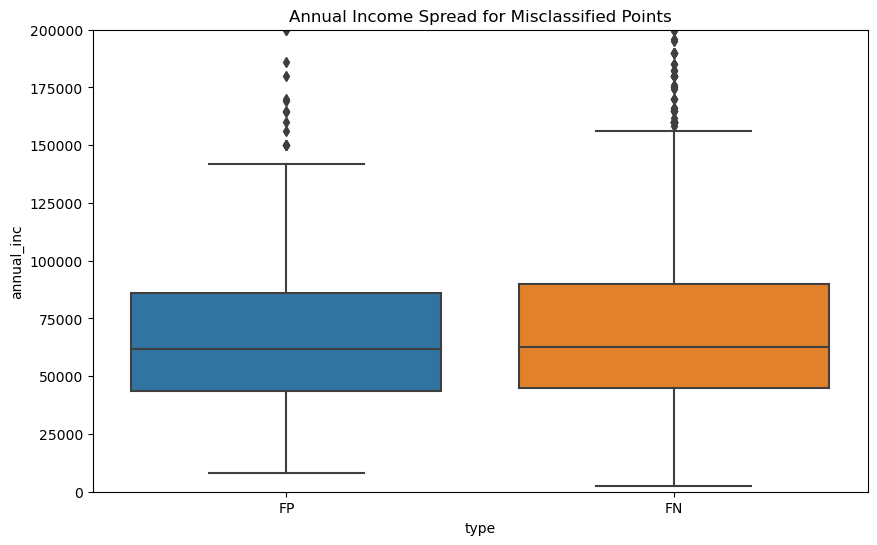

In [89]:
# Boxplot of annual_inc
plt.figure(figsize=(10,6))
sns.boxplot(x='type', y='annual_inc', data=misclassified)
plt.title('Annual Income Spread for Misclassified Points')
plt.ylim(0,200000)
plt.show()

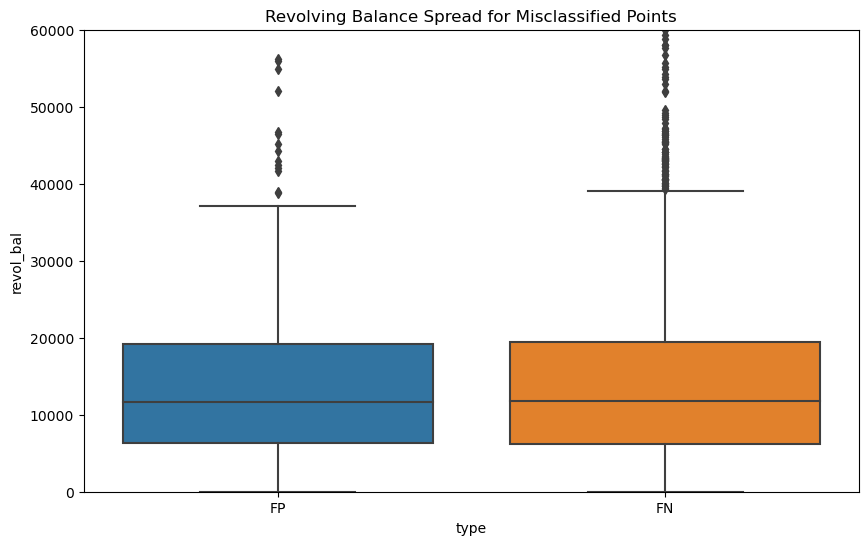

In [90]:
# Boxplot of revol_bal
plt.figure(figsize=(10,6))
sns.boxplot(x='type', y='revol_bal', data=misclassified)
plt.title('Revolving Balance Spread for Misclassified Points')
plt.ylim(0,60000)
plt.show()

# Remarks & Further Directions

> I would've liked to conduct more extensive Optuna studies with more trials, but was limited by the extensive training time. The Optuna study above alone took >2 hours. Conducting several studies turned out to just be impractical. 

> Similarly, I wanted to conduct a seperate Optuna study tuning only over neural networks of varying architecture.

> I would've preferred to include a `SupportVectorClassifier` in the study, but again was limited by my computational resources.